# Parcial 3

**Integrantes:** Juliana Bermúdez y  Valentina Herrera

**Objetivo:** a partir de lo observado por el Observatorio Mauna Loa en Hawaii predecir la cantidad de CO2 anual.

## Lectura y preprocesamiento

Librerias

In [ ]:
import numpy as np
import pandas as pd
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Union
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
import math
warnings.filterwarnings("ignore", message="Could not infer format")
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/co2_mm_mlo.csv')
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            793 non-null    int64  
 1   month           793 non-null    int64  
 2   decimal date    793 non-null    float64
 3   average         793 non-null    float64
 4   deseasonalized  793 non-null    float64
 5   ndays           793 non-null    int64  
 6   sdev            793 non-null    float64
 7   unc             793 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 49.7 KB


Quitamos las últimas tres variables dado que no aportan a lo que se va a hacer. Además, quitamos year y month dado que con decimal date es suficiente para hacer la serie de tiempo.

In [ ]:
from datetime import date
df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)
df['date'] = df[["year","month"]].agg("-".join, axis=1)
df['date'] = pd.to_datetime(df['date'], format="%Y-%m")

In [ ]:
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc,date
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99,1958-03-01
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99,1958-04-01
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99,1958-05-01
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99,1958-06-01
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99,1958-07-01


In [ ]:
df = df.drop(columns=['ndays', 'sdev', 'unc', 'month', 'year', 'decimal date'])

In [ ]:
df.set_index('date', inplace=True)
df.head()

,average,deseasonalized
date,,
1958-03-01,315.70,314.43
1958-04-01,317.45,315.16
1958-05-01,317.51,314.71
1958-06-01,317.24,315.14
1958-07-01,315.86,315.18


## Visualización y Análisis de la Serie Temporal

Dado que se tienen dos variables con las que se podría armar la serie de tiempo, se generan series de tiempo con ambas para definir cual es la que se va a utilizar.

### Identificación de variable para la serie de tiempo

#### Serie de tiempo con deseasonalized.

Se genera la serie de tiempo con deseasonalized para identificar cual de las dos variables es la óptima.

In [ ]:
df_des = df.drop(columns = ['average'])
ts_des = pd.Series(df_des.unstack().values, index=df_des.index)

<Axes: xlabel='date'>

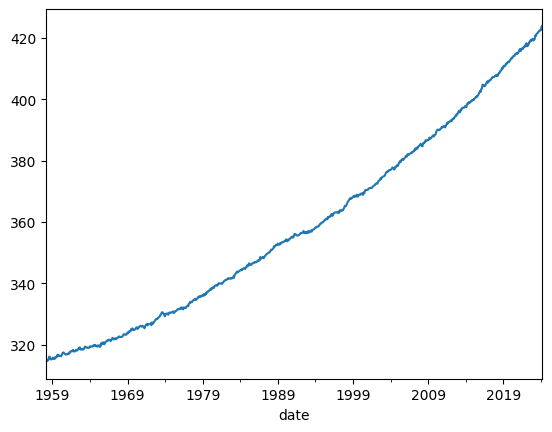

In [ ]:
ts_des.plot()

Como se esperaba, estos datos solo tienen la tendencia dado que quitaron la estacionalidad. Por tanto, no se va a utilizar está variable.

#### Serie de tiempo con el promedio

Se genera la serie de tiempo con el promedio para definir si es adecuado hacer la serie de tiempo a partir de estos datos.

In [ ]:
df_average = df.drop(columns=['deseasonalized'])
ts_average = pd.Series(df_average.unstack().values, index=df_average.index)

<Axes: xlabel='date'>

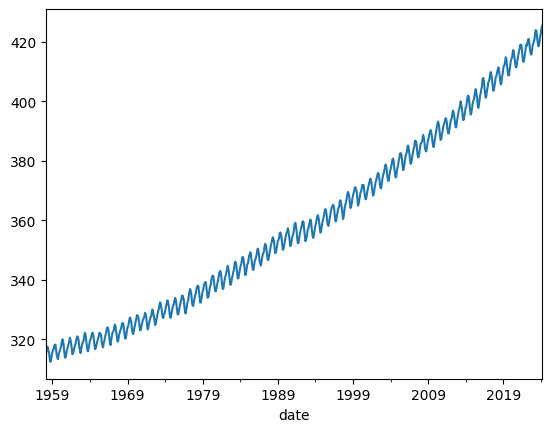

In [ ]:
ts_average.plot()

Se evidencia que hay una fuerte tendencia creciente en los datos que debe ser removida, sin embargo, acá si es posible ver la estacionalidad. Por tanto, se va a trabajar sobre estos datos.

## Prueba de estacionariedad

A pesar de lo identificado con el análisis gráfico, se deben hacer pruebas para corroborar que hay estacionariedad. Para ello, utilizamos la función dada en el taller de series de tiempo.

In [ ]:
def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }


In [ ]:
adf_test_results = test_stationarity(ts_average)
adf_test_results

{'ADF Statistic': 6.204525491050962,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.4388599939707056,
  '5%': -2.865295977855759,
  '10%': -2.5687700561872413},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

Como el p-value es mayor a 0.05 (significancia elegida), se sabe que la serie de tiempo no es estacionario y por tanto debe volverse estacionaria.

## Diferenciación

Se utiliza diferenciación para intentar eliminar la estacionariedad. Para ello, se aplica la función dada en el taller, la cual diferencia hasta que por el p-valor y las demás métricas se pueda decir que es estacionaria.

In [ ]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 1 # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results


In [ ]:
diff_count, diff_series, adf_results = make_stationary_recursive(ts_average, max_diff=3)
diff_count, adf_results

(2,
 {'ADF Statistic': -5.238158439989721,
  'p-value': 7.344619920331818e-06,
  'Critical Values': {'1%': -3.4388710830827125,
   '5%': -2.8653008652386576,
   '10%': -2.568772659807725},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

A partir de los resultados, se encuentra que para llevar a la serie a ser estacionaria se debe hacer diferenciación dos veces. Igual, se grafica la serie de tiempo para ver si efectivamente se removio la tendencia.

<Axes: xlabel='date'>

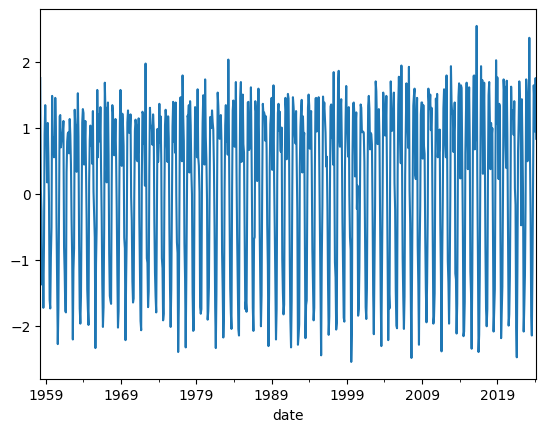

In [ ]:
diff_series.plot()

Se encuentra que efectivamente la tendencia fue removida con una sola diferenciación y por tanto se debe tomar la serie ```diff_series```.



## División de la serie de tiempo

Para encontrar los mejores parámetros, es necesario dividir la serie de tiempo en train, validation y test. Primero, se decide que el 80% de los datos van a estar destinados a entrenamiento y validación, mientras que el otro 20% va a ser para probar al final el modelo.

In [ ]:
train_val_size = int(len(diff_series) * 0.8)
train_val, test = diff_series[:train_val_size], diff_series[train_val_size:]
len(train_val), len(test)

(633, 159)

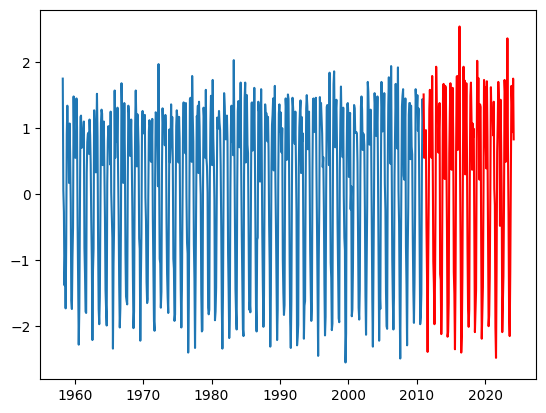

In [ ]:
plt.plot(train_val)
plt.plot(test, color='r');

Ahora, del conjunto que se tiene para entrenamiento y validación se va a tomar el 20% para encontrar los mejores parámetros y posteriormente se va a ir haciendo validación cruzada.

## Identificación de Parámetros del Modelo Arima

Antes de elegir los valores de p y de q, se hace autocorrelación y autocorrelación parcial con diferentes lags para entender más o menos cómo se van a ir ajustando los valores.

### Autocorrelación (ACF)

In [ ]:
vnlag=12
lag_acf = acf(train_val, nlags=vnlag)
lag_pacf = pacf(train_val, nlags=vnlag, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

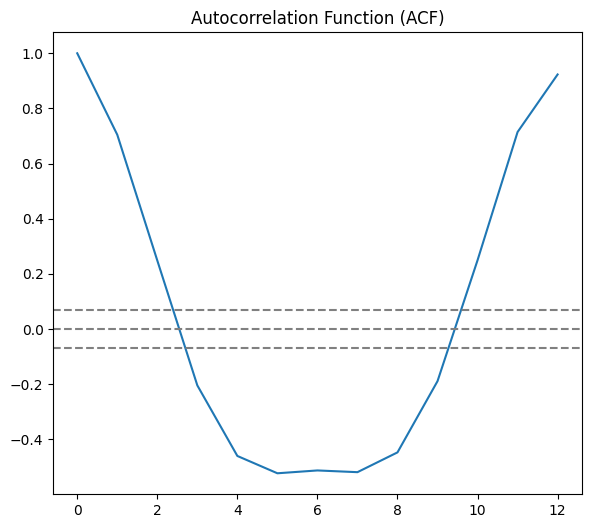

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')


### Autocorrelacion Parcial (PACF)

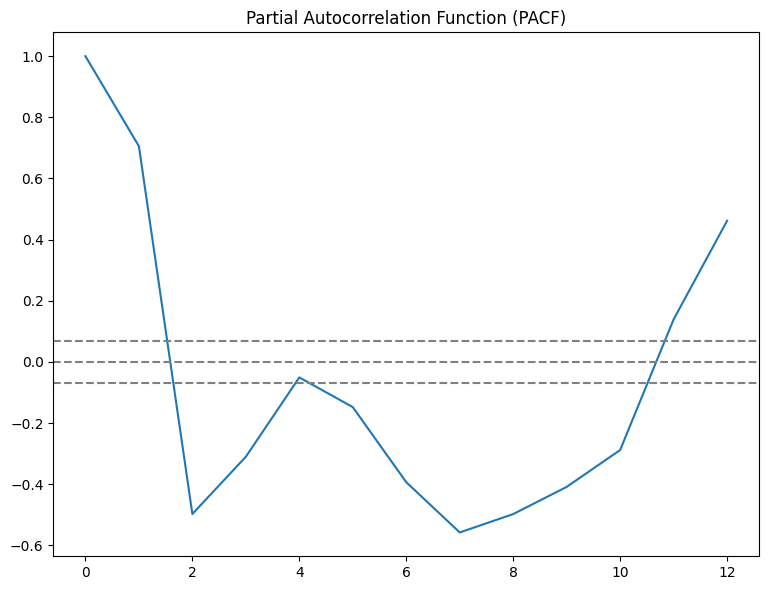

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()


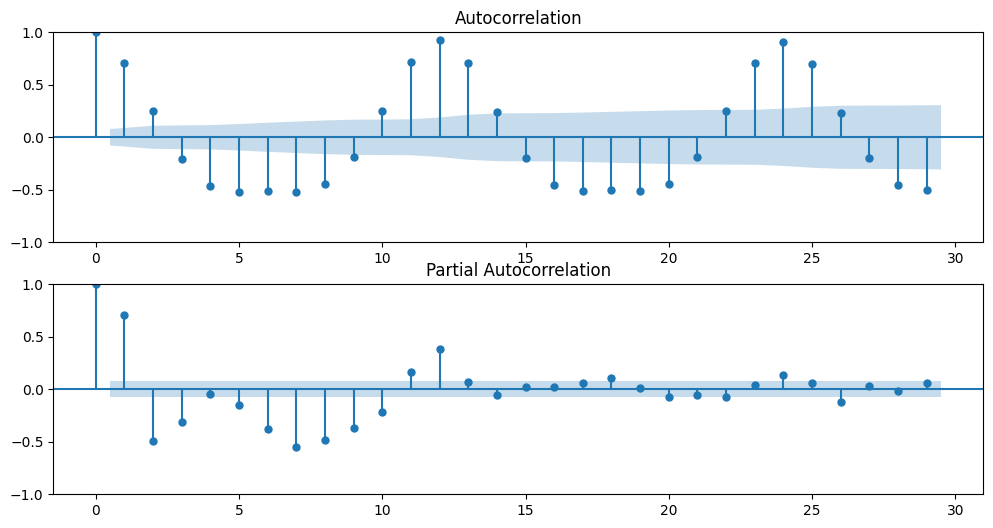

In [ ]:
plt.subplots(figsize=(12, 6))
plt.subplot(211)
plot_acf(train_val, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_val, ax=plt.gca())
plt.show()

Ahora, a partir de la autocorrelación parcial podemos identificar que los valores de p serán múltiplos del primer y segundo mes que tienen índice 0 y 1. Adicionamlente, a partir de la autocorrelación podemos ver que los valores de q serán múltiplos de los primeros 3 meses que tendrán índice 0,1 y 2.

## Encontrando el mejor modelo

### Mejor ARIMA con datos de entrenamiento

Dado el comportamiento de la gráfica, se determina que se van a hacer 5 folds para entrenar el modelo. Para ello, se va a utilizar la función timesplit.

In [ ]:
tscv = TimeSeriesSplit(n_splits= 5)
list_ps = []
list_qs = []
for i, (train_index, test_index) in enumerate(tscv.split(train_val)):
     #print(f"Fold {i}:")
     #print(f"  Train: index={train_index}")
     #print(f"  Test:  index={test_index}")
     qs = [0,1,2,3,12,13,14]
     ps = [0,1,2,12,13,24,25]
     order_list = list(product(ps, qs))
     best_aic = math.inf
     best_p = 0
     best_q = 0
     train_data = train_val.iloc[train_index]
     for order in tqdm_notebook(order_list):
        print(f'Evaluando {order}')
        model = ARIMA(train_data, order=(order[0], 0, order[1])).fit() #Es cero porque se ingresó el modelo ya derivado

        if model.aic < best_aic:
          best_aic = model.aic
          best_p = order[0]
          best_q = order[1]
     list_ps.append(best_p)
     list_qs.append(best_q)
     print(f'El mejor aic es {best_aic} con p = {best_p} y q = {best_q}')
     #print(order_list)
     #print(f'Valores de q {qs}')
     #print(f'Valores de p {ps}')


  0%|          | 0/49 [00:00<?, ?it/s]

Evaluando (0, 0)
Evaluando (0, 1)
Evaluando (0, 2)
Evaluando (0, 3)
Evaluando (0, 12)
Evaluando (0, 13)
Evaluando (0, 14)
Evaluando (1, 0)
Evaluando (1, 1)
Evaluando (1, 2)
Evaluando (1, 3)
Evaluando (1, 12)
Evaluando (1, 13)
Evaluando (1, 14)
Evaluando (2, 0)
Evaluando (2, 1)
Evaluando (2, 2)
Evaluando (2, 3)
Evaluando (2, 12)
Evaluando (2, 13)
Evaluando (2, 14)
Evaluando (12, 0)
Evaluando (12, 1)
Evaluando (12, 2)
Evaluando (12, 3)
Evaluando (12, 12)
Evaluando (12, 13)
Evaluando (12, 14)
Evaluando (13, 0)
Evaluando (13, 1)
Evaluando (13, 2)
Evaluando (13, 3)
Evaluando (13, 12)
Evaluando (13, 13)
Evaluando (13, 14)
Evaluando (24, 0)
Evaluando (24, 1)
Evaluando (24, 2)
Evaluando (24, 3)
Evaluando (24, 12)
Evaluando (24, 13)
Evaluando (24, 14)
Evaluando (25, 0)
Evaluando (25, 1)
Evaluando (25, 2)
Evaluando (25, 3)
Evaluando (25, 12)
Evaluando (25, 13)
Evaluando (25, 14)
El mejor aic es 111.86936680791176 con p = 13 y q = 0


  0%|          | 0/49 [00:00<?, ?it/s]

Evaluando (0, 0)
Evaluando (0, 1)
Evaluando (0, 2)
Evaluando (0, 3)
Evaluando (0, 12)
Evaluando (0, 13)
Evaluando (0, 14)
Evaluando (1, 0)
Evaluando (1, 1)
Evaluando (1, 2)
Evaluando (1, 3)
Evaluando (1, 12)
Evaluando (1, 13)
Evaluando (1, 14)
Evaluando (2, 0)
Evaluando (2, 1)
Evaluando (2, 2)
Evaluando (2, 3)
Evaluando (2, 12)
Evaluando (2, 13)
Evaluando (2, 14)
Evaluando (12, 0)
Evaluando (12, 1)
Evaluando (12, 2)
Evaluando (12, 3)
Evaluando (12, 12)
Evaluando (12, 13)
Evaluando (12, 14)
Evaluando (13, 0)
Evaluando (13, 1)
Evaluando (13, 2)
Evaluando (13, 3)
Evaluando (13, 12)
Evaluando (13, 13)
Evaluando (13, 14)
Evaluando (24, 0)
Evaluando (24, 1)
Evaluando (24, 2)
Evaluando (24, 3)
Evaluando (24, 12)
Evaluando (24, 13)
Evaluando (24, 14)
Evaluando (25, 0)
Evaluando (25, 1)
Evaluando (25, 2)
Evaluando (25, 3)
Evaluando (25, 12)
Evaluando (25, 13)
Evaluando (25, 14)
El mejor aic es 157.24392355172816 con p = 12 y q = 12


  0%|          | 0/49 [00:00<?, ?it/s]

Evaluando (0, 0)
Evaluando (0, 1)
Evaluando (0, 2)
Evaluando (0, 3)
Evaluando (0, 12)
Evaluando (0, 13)
Evaluando (0, 14)
Evaluando (1, 0)
Evaluando (1, 1)
Evaluando (1, 2)
Evaluando (1, 3)
Evaluando (1, 12)
Evaluando (1, 13)
Evaluando (1, 14)
Evaluando (2, 0)
Evaluando (2, 1)
Evaluando (2, 2)
Evaluando (2, 3)
Evaluando (2, 12)
Evaluando (2, 13)
Evaluando (2, 14)
Evaluando (12, 0)
Evaluando (12, 1)
Evaluando (12, 2)
Evaluando (12, 3)
Evaluando (12, 12)
Evaluando (12, 13)
Evaluando (12, 14)
Evaluando (13, 0)
Evaluando (13, 1)
Evaluando (13, 2)
Evaluando (13, 3)
Evaluando (13, 12)
Evaluando (13, 13)
Evaluando (13, 14)
Evaluando (24, 0)
Evaluando (24, 1)
Evaluando (24, 2)
Evaluando (24, 3)
Evaluando (24, 12)
Evaluando (24, 13)
Evaluando (24, 14)
Evaluando (25, 0)
Evaluando (25, 1)
Evaluando (25, 2)
Evaluando (25, 3)
Evaluando (25, 12)
Evaluando (25, 13)
Evaluando (25, 14)
El mejor aic es 209.9925290944386 con p = 12 y q = 12


  0%|          | 0/49 [00:00<?, ?it/s]

Evaluando (0, 0)
Evaluando (0, 1)
Evaluando (0, 2)
Evaluando (0, 3)
Evaluando (0, 12)
Evaluando (0, 13)
Evaluando (0, 14)
Evaluando (1, 0)
Evaluando (1, 1)
Evaluando (1, 2)
Evaluando (1, 3)
Evaluando (1, 12)
Evaluando (1, 13)
Evaluando (1, 14)
Evaluando (2, 0)
Evaluando (2, 1)
Evaluando (2, 2)
Evaluando (2, 3)
Evaluando (2, 12)
Evaluando (2, 13)
Evaluando (2, 14)
Evaluando (12, 0)
Evaluando (12, 1)
Evaluando (12, 2)
Evaluando (12, 3)
Evaluando (12, 12)
Evaluando (12, 13)
Evaluando (12, 14)
Evaluando (13, 0)
Evaluando (13, 1)
Evaluando (13, 2)
Evaluando (13, 3)
Evaluando (13, 12)
Evaluando (13, 13)
Evaluando (13, 14)
Evaluando (24, 0)
Evaluando (24, 1)
Evaluando (24, 2)
Evaluando (24, 3)
Evaluando (24, 12)
Evaluando (24, 13)
Evaluando (24, 14)
Evaluando (25, 0)
Evaluando (25, 1)
Evaluando (25, 2)
Evaluando (25, 3)
Evaluando (25, 12)
Evaluando (25, 13)
Evaluando (25, 14)
El mejor aic es 268.9812412188785 con p = 13 y q = 14


  0%|          | 0/49 [00:00<?, ?it/s]

Evaluando (0, 0)
Evaluando (0, 1)
Evaluando (0, 2)
Evaluando (0, 3)
Evaluando (0, 12)
Evaluando (0, 13)
Evaluando (0, 14)
Evaluando (1, 0)
Evaluando (1, 1)
Evaluando (1, 2)
Evaluando (1, 3)
Evaluando (1, 12)
Evaluando (1, 13)
Evaluando (1, 14)
Evaluando (2, 0)
Evaluando (2, 1)
Evaluando (2, 2)
Evaluando (2, 3)
Evaluando (2, 12)
Evaluando (2, 13)
Evaluando (2, 14)
Evaluando (12, 0)
Evaluando (12, 1)
Evaluando (12, 2)
Evaluando (12, 3)
Evaluando (12, 12)
Evaluando (12, 13)
Evaluando (12, 14)
Evaluando (13, 0)
Evaluando (13, 1)
Evaluando (13, 2)
Evaluando (13, 3)
Evaluando (13, 12)
Evaluando (13, 13)
Evaluando (13, 14)
Evaluando (24, 0)
Evaluando (24, 1)
Evaluando (24, 2)
Evaluando (24, 3)
Evaluando (24, 12)
Evaluando (24, 13)
Evaluando (24, 14)
Evaluando (25, 0)
Evaluando (25, 1)
Evaluando (25, 2)
Evaluando (25, 3)
Evaluando (25, 12)
Evaluando (25, 13)
Evaluando (25, 14)
El mejor aic es 310.86597546641997 con p = 13 y q = 12


Encontramos los mejores parámetros.

In [ ]:
list_ps

In [ ]:
list_qs

[0, 12, 12, 14, 12]

Visualizamos como se ven las predicciones del mejor modelo sobre los datos reales.

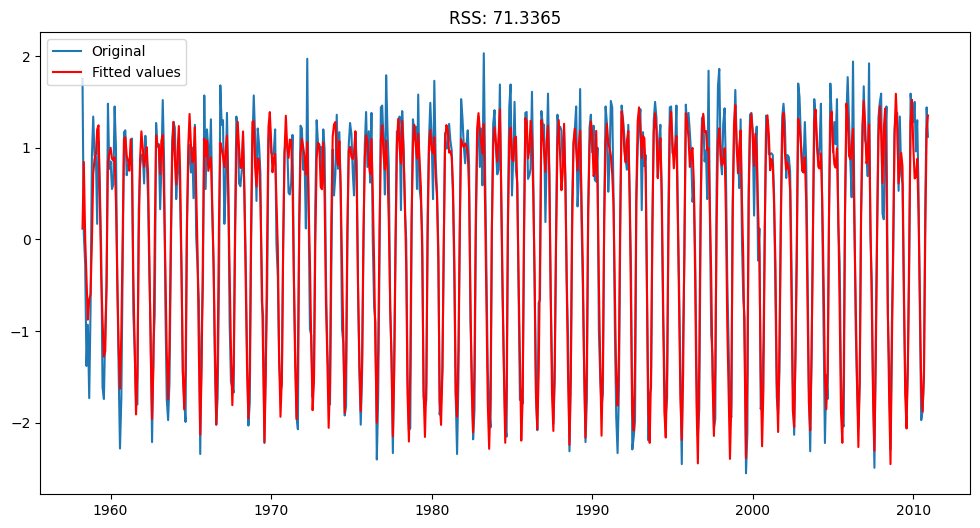

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:               ARIMA(13, 0, 12)   Log Likelihood                -190.293
Date:                Sun, 05 May 2024   AIC                            434.586
Time:                        00:59:46   BIC                            554.749
Sample:                    04-01-1958   HQIC                           481.250
                         - 12-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1178      0.010     11.341      0.000       0.097       0.138
ar.L1         -0.6739      0.166     -4.067      0.000      -0.999      -0.349
ar.L2          0.0306      0.108      0.284      0.7

In [ ]:
# Ajustando el modelo ARIMA
model = ARIMA(train_val, order=(13, 0, 12))
results = model.fit()

# Visualización de la serie de entrenamiento y los valores ajustados
plt.figure(figsize=(12, 6))
plt.plot(train_val, label='Original')
plt.plot(results.fittedvalues, color='red', label='Fitted values')
plt.title('RSS: %.4f' % sum((results.fittedvalues - train_val)**2))
plt.legend()
plt.show()

print(results.summary())

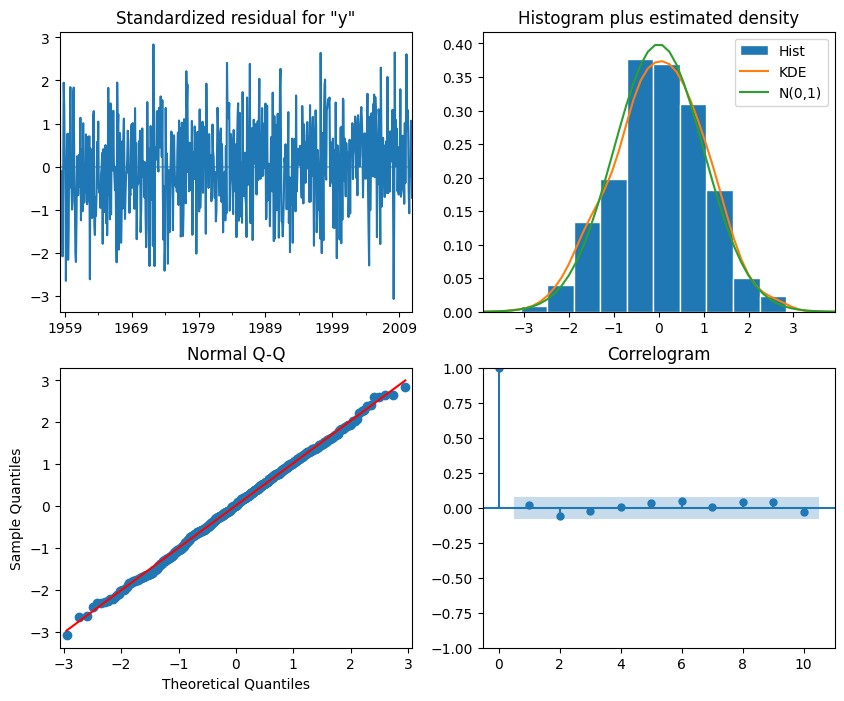

In [ ]:
results.plot_diagnostics(figsize=(10,8));

Luego, encontramos unos parámetros que sobre el mismo conjunto de entrenamiento ya no tienen tendencia y los errores son bien comportados.

### Prueba mejor modelo con testeo


#### Predicción

Ahora se buscan las predicciones del mejor modelo para el conjunto de testeo y se encuentran las métricas RMSE y MSE.

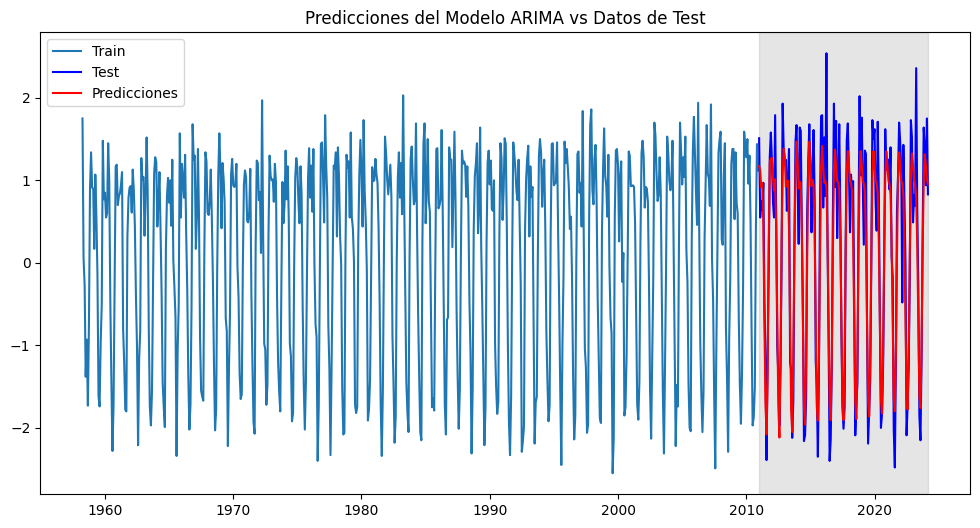

(0.22380691463067487, 0.47308235501937174)

In [ ]:
predictions = results.get_forecast(steps=len(test))
predicted_mean = predictions.predicted_mean

# Convertir las predicciones a una serie para facilitar la comparación
predicted_series = pd.Series(predicted_mean, index=test.index)

# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_val, label='Train')
ax.plot(test, label='Test', color='blue')
ax.plot(predicted_series, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')

fecha_inicio = test.index[0]
fecha_fin = test.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)

plt.show()

mse = mean_squared_error(test, predicted_series)
rmse = np.sqrt(mse)

mse, rmse

Luego, encontramos que las métricas a pesar de no ser ideales tampoco representan que el error sea tan alto ya que es aproximadamente el 10%.Ahora, probamos rolling forecast para encontrar las métricas nuevamente.

In [ ]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []

    for i in tqdm_notebook(range(train_len, total_len)):
        end_idx = min(i + window, total_len)
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(end_idx - i)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [ ]:
TRAIN_LEN = len(train_val)
HORIZON = len(test)
WINDOW = 12
pred_ARIMA = rolling_forecast(diff_series, TRAIN_LEN, HORIZON, WINDOW, (13,0,12))
fechas = test.index
st_pred_ARIMA = pd.Series(pred_ARIMA[:len(fechas)], index=fechas)

mse = mean_squared_error(test, st_pred_ARIMA)
rmse = np.sqrt(mse)

mse, rmse

  0%|          | 0/159 [00:00<?, ?it/s]

(2.9939786503826715, 1.7303117205817775)

Tenemos que las métricas apuntan a que el modelo ARIMA esta dando predicciones con un error moderado. Sin embargo, ahora volvemos a buscar los mejores hiperparámetros pero ahora si teniendo en cuenta más métricas y todo el conjunto.

In [ ]:
def evaluate_arima_model(df, train_len, horizon: int, window: int, order: list):

    try:
        pred_ARIMA = rolling_forecast(df, train_len, horizon, window, order)
        test = df[train_len:train_len + len(pred_ARIMA)]
        print("Longitud de test:", len(test))
        print("Longitud de pred_ARIMA:", len(pred_ARIMA))
        rmse = np.sqrt(mean_squared_error(test, pred_ARIMA))
    except Exception as e:
        print("Error al calcular RMSE para el modelo ARIMA {}: {}".format(order, e))
        rmse = np.inf
    return rmse


def evaluate_models(df, p_values, d_values, q_values):

    train_size = int(len(df) * 0.8)
    train_val, test = df[:train_size], df[train_size:]

    TRAIN_LEN = len(train_val)
    HORIZON = len(test)
    WINDOW = 1
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(df, TRAIN_LEN, HORIZON, WINDOW, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except Exception as e:
                    print("Error:", e)
                    continue

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
ps = [12,13]
qs = [0,12,14]
ds  = [1, 2]
evaluate_models(diff_series, ps, ds, qs)

  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(12, 1, 0) RMSE=0.431


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(12, 1, 12) RMSE=0.402


  0%|          | 0/159 [00:00<?, ?it/s]

Error al calcular RMSE para el modelo ARIMA (12, 1, 14): LU decomposition error.
ARIMA(12, 1, 14) RMSE=inf


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(12, 2, 0) RMSE=0.580


  0%|          | 0/159 [00:00<?, ?it/s]

Error al calcular RMSE para el modelo ARIMA (12, 2, 12): LU decomposition error.
ARIMA(12, 2, 12) RMSE=inf


  0%|          | 0/159 [00:00<?, ?it/s]

Error al calcular RMSE para el modelo ARIMA (12, 2, 14): LU decomposition error.
ARIMA(12, 2, 14) RMSE=inf


  0%|          | 0/159 [00:00<?, ?it/s]

Error al calcular RMSE para el modelo ARIMA (13, 1, 0): LU decomposition error.
ARIMA(13, 1, 0) RMSE=inf


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(13, 1, 12) RMSE=0.421


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(13, 1, 14) RMSE=0.398


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(13, 2, 0) RMSE=0.524


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(13, 2, 12) RMSE=0.442


  0%|          | 0/159 [00:00<?, ?it/s]

Longitud de test: 159
Longitud de pred_ARIMA: 159
ARIMA(13, 2, 14) RMSE=0.416
Best ARIMA(13, 1, 14) RMSE=0.398


A partir de los resultados, podemos concluir que el mejor modelo encontrado fue ARIMA(13, 1, 14) con un RMSE de 0.398.

##### Mejor modelo

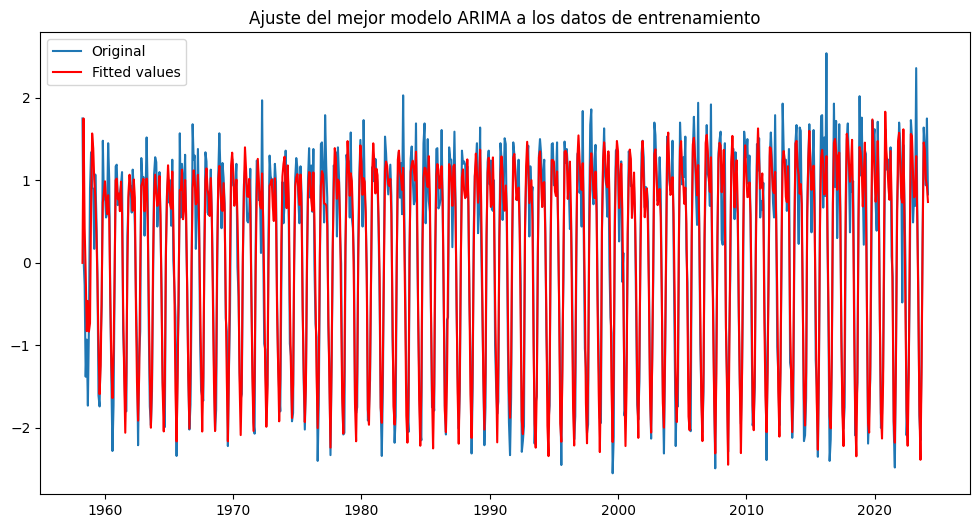

In [ ]:
best_order = (13, 1, 14)
best_model = ARIMA(diff_series, order=best_order)
best_results = best_model.fit()

plt.figure(figsize=(12, 6))
plt.plot(diff_series, label='Original')
plt.plot(best_results.fittedvalues, color='red', label='Fitted values')
plt.title('Ajuste del mejor modelo ARIMA a los datos de entrenamiento')
plt.legend()
plt.show()
